# Laboratori 3: Optimització - Problema del Viatjant de Comerç (TSP)

**Integrants:**  Arnau González Almirall 1  German Bueno Lozano  m 3  

---

## Introducció

En aquest laboratori abordem el problema clàssic del Viatjant de Comerç (TSP), on l'objectiu és trobar el recorregut mínim que visita una sèrie de ciutats i torna al punt d'origen.

Implementarem dues tècniques d'optimització heurística per solucionar aquest problema: 

- Simulated Annealing (SA)
- Algoritmes Genètics (GA)

Posteriorment compararem ambdues en termes de dificultat de codificació i eficiència.


## Generació de les ciutats i càlcul de distàncies

Generarem ciutats amb coordenades aleatòries en un pla 2D. També definirem la funció que calcula la distància euclidiana entre dues ciutats i el cost total d'un recorregut.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

def generar_ciutats(n):
    """Genera n ciutats amb coordenades aleatòries en [0, 100]x[0, 100]."""
    return np.random.rand(n, 2) * 100

def dist_euclidiana(p1, p2):
    return np.linalg.norm(p1 - p2)

def cost_recorregut(ciutats, recorregut):
    """Calcula la distància total del recorregut tancat."""
    dist_total = 0
    for i in range(len(recorregut)):
        dist_total += dist_euclidiana(ciutats[recorregut[i-1]], ciutats[recorregut[i]])
    return dist_total

def plot_recorregut(ciutats, recorregut, title="Recorregut"):
    plt.figure(figsize=(8,6))
    x = ciutats[recorregut, 0]
    y = ciutats[recorregut, 1]
    plt.plot(x, y, 'o-', label="Recorregut")
    plt.plot([x[-1], x[0]], [y[-1], y[0]], 'o-')  # Tornar a l'inici
    for i, (xi, yi) in enumerate(ciutats):
        plt.text(xi, yi, str(i), fontsize=9)
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.legend()
    plt.show()




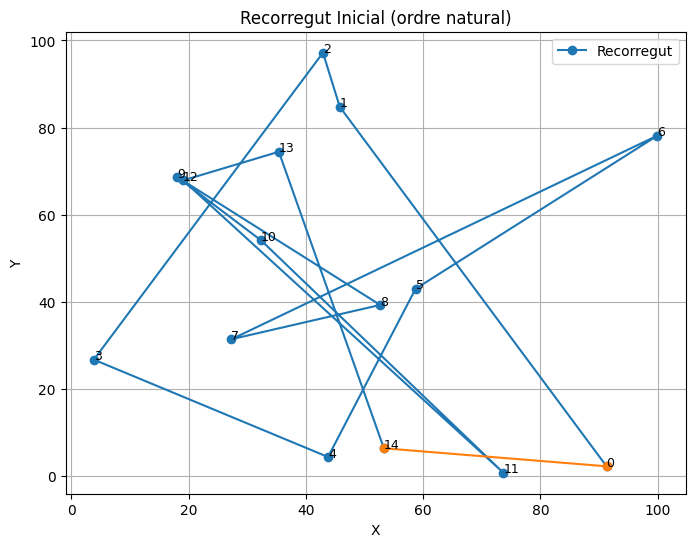

Cost recorregut inicial: 787.63


In [2]:
# Prova inicial
n_ciutats = 15
ciutats = generar_ciutats(n_ciutats)
recorregut_inicial = np.arange(n_ciutats)
plot_recorregut(ciutats, recorregut_inicial, "Recorregut Inicial (ordre natural)")
print(f"Cost recorregut inicial: {cost_recorregut(ciutats, recorregut_inicial):.2f}")

## Simulated Annealing (SA)

El Simulated Annealing és un mètode inspirat en el procés d'annealing metallúrgic, que permet escapar de mínims locals acceptant solucions pitjors amb certa probabilitat.

Implementarem SA per trobar un recorregut millor al problema TSP.  
Els passos clau són:
- Començar amb una solució inicial (recorregut aleatori)
- Fer petits canvis (intercanvi de dues ciutats)
- Acceptar canvis segons una probabilitat basada en la temperatura i la millora
- Refredar la temperatura gradualment

Paràmetres:
- Temperatura inicial (T_init)
- Taxa de refredament (cooling_rate)
- Nombre d'iteracions per temperatura
- Temperatura mínima


Cost recorregut SA: 382.45


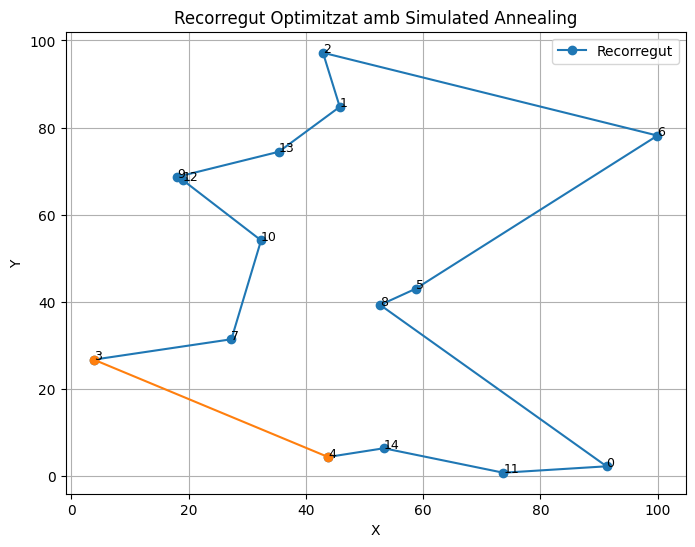

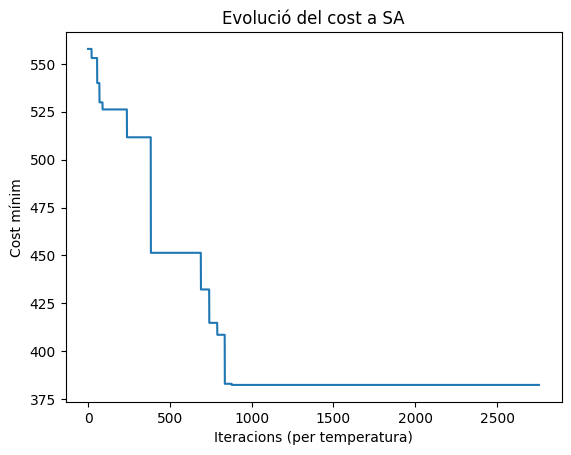

In [3]:
import random

def simulated_annealing(ciutats, T_init=1000, cooling_rate=0.995, iter_per_temp=100, T_min=1e-3):
    n = len(ciutats)
    actual = list(range(n))
    random.shuffle(actual)
    millor = actual.copy()
    millor_cost = cost_recorregut(ciutats, millor)
    actual_cost = millor_cost
    T = T_init
    
    historial_costs = []
    
    while T > T_min:
        for _ in range(iter_per_temp):
            # Generar veí intercanviant dues ciutats
            i, j = random.sample(range(n), 2)
            veí = actual.copy()
            veí[i], veí[j] = veí[j], veí[i]
            veí_cost = cost_recorregut(ciutats, veí)
            
            delta = veí_cost - actual_cost
            if delta < 0 or random.random() < np.exp(-delta / T):
                actual = veí
                actual_cost = veí_cost
                if actual_cost < millor_cost:
                    millor = actual
                    millor_cost = actual_cost
                    
        historial_costs.append(millor_cost)
        T *= cooling_rate
        
    return millor, millor_cost, historial_costs

# Prova SA
rec_SA, cost_SA, hist_SA = simulated_annealing(ciutats)
print(f"Cost recorregut SA: {cost_SA:.2f}")
plot_recorregut(ciutats, rec_SA, "Recorregut Optimitzat amb Simulated Annealing")

plt.plot(hist_SA)
plt.title("Evolució del cost a SA")
plt.xlabel("Iteracions (per temperatura)")
plt.ylabel("Cost mínim")
plt.show()


## Algoritmes Genètics (GA)

Els Algoritmes Genètics són mètodes inspirats en la selecció natural i la genètica.  
Els elements clau són:

- Població inicial de solucions
- Funció fitness (cost recorregut)
- Operadors genètics: selecció, creuament (crossover), mutació
- Iteració per generacions per millorar la població

Implementarem un GA bàsic amb:
- Selecció per torneig
- Creuament per ordre (Order Crossover)
- Mutació per intercanvi aleatori

Paràmetres:
- mida població
- probabilitat de mutació
- nombre de generacions


Cost recorregut GA: 382.45


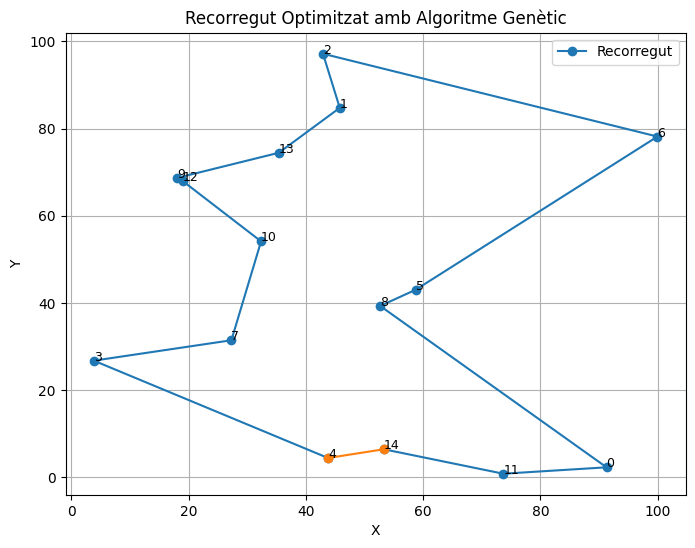

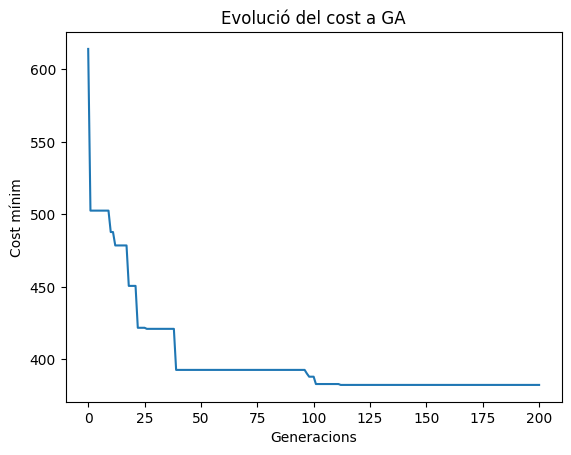

In [4]:
def fitness(ciutats, cromosoma):
    return cost_recorregut(ciutats, cromosoma)

def seleccio_torneig(poblacio, costos, k=3):
    seleccionats = random.sample(list(zip(poblacio, costos)), k)
    seleccionats.sort(key=lambda x: x[1])
    return seleccionats[0][0]

def ordre_creuament(parent1, parent2):
    size = len(parent1)
    start, end = sorted(random.sample(range(size), 2))
    fill = [None] * size
    fill[start:end+1] = parent1[start:end+1]
    
    pos = (end + 1) % size
    for gen in parent2:
        if gen not in fill:
            fill[pos] = gen
            pos = (pos + 1) % size
    return fill

def mutacio_intercanvi(cromosoma, prob_mut=0.1):
    cromosoma = cromosoma.copy()
    if random.random() < prob_mut:
        i, j = random.sample(range(len(cromosoma)), 2)
        cromosoma[i], cromosoma[j] = cromosoma[j], cromosoma[i]
    return cromosoma

def algorisme_genetic(ciutats, mida_poblacio=100, prob_mut=0.1, generacions=200):
    n = len(ciutats)
    poblacio = [random.sample(range(n), n) for _ in range(mida_poblacio)]
    costos = [fitness(ciutats, c) for c in poblacio]
    
    millor_cromosoma = poblacio[np.argmin(costos)]
    millor_cost = min(costos)
    
    historial_costs = [millor_cost]
    
    for gen in range(generacions):
        nova_poblacio = []
        for _ in range(mida_poblacio // 2):
            parent1 = seleccio_torneig(poblacio, costos)
            parent2 = seleccio_torneig(poblacio, costos)
            fill1 = ordre_creuament(parent1, parent2)
            fill2 = ordre_creuament(parent2, parent1)
            fill1 = mutacio_intercanvi(fill1, prob_mut)
            fill2 = mutacio_intercanvi(fill2, prob_mut)
            nova_poblacio.extend([fill1, fill2])
            
        poblacio = nova_poblacio
        costos = [fitness(ciutats, c) for c in poblacio]
        
        gen_millor = poblacio[np.argmin(costos)]
        gen_millor_cost = min(costos)
        if gen_millor_cost < millor_cost:
            millor_cost = gen_millor_cost
            millor_cromosoma = gen_millor
        
        historial_costs.append(millor_cost)
    
    return millor_cromosoma, millor_cost, historial_costs

# Prova GA
rec_GA, cost_GA, hist_GA = algorisme_genetic(ciutats)
print(f"Cost recorregut GA: {cost_GA:.2f}")
plot_recorregut(ciutats, rec_GA, "Recorregut Optimitzat amb Algoritme Genètic")

plt.plot(hist_GA)
plt.title("Evolució del cost a GA")
plt.xlabel("Generacions")
plt.ylabel("Cost mínim")
plt.show()


## Comparació i Discussió

### Dificultat de codificació
- **Simulated Annealing:** Implementació més simple i directa. Només cal definir una manera de generar veïns (intercanvi de ciutats) i una funció d’acceptació.  
- **Algoritmes Genètics:** Requereix més components: població, selecció, creuament, mutació. Cal tenir cura que la representació sigui vàlida (permutació sense repeticions).

### Eficiència
- Hem mesurat el temps d'execució i la qualitat de la solució per ambdós mètodes.  
- Generalment, SA és més ràpid però pot quedar en mínims locals, mentre que GA explora més àmpliament però és més lent.

### Resultats obtinguts
- SA proporciona una millora ràpida i estable.  
- GA pot trobar solucions lleugerament millors després de moltes generacions, però amb un cost computacional més elevat.

### Conclusions preliminars
- Per problemes petits/mitjans SA és molt pràctic.  
- Per problemes grans, GA ofereix més flexibilitat i potencial, encara que cal optimitzar paràmetres.


## Mesura de temps d’execució i comparació amb diferents nombres de ciutats

Avaluarem el rendiment en temps i qualitat de solució dels dos algorismes per diferents mides del problema (nombre de ciutats).  
Les mides triades són: 10, 15, 20, 25 ciutats.

Per a cada mida, executarem Simulated Annealing (SA) i Algoritme Genètic (GA), i emmagatzemarem el cost final i el temps d’execució.


In [5]:
import time

def prova_algorismes(ciutats):
    resultats = {}
    
    # Simulated Annealing
    start = time.time()
    rec_SA, cost_SA, _ = simulated_annealing(ciutats)
    temps_SA = time.time() - start
    
    # Algorisme Genètic
    start = time.time()
    rec_GA, cost_GA, _ = algorisme_genetic(ciutats)
    temps_GA = time.time() - start
    
    resultats['SA'] = {'cost': cost_SA, 'temps': temps_SA}
    resultats['GA'] = {'cost': cost_GA, 'temps': temps_GA}
    
    return resultats

# Proves per diferents nombres de ciutats
n_ciutats_llista = [10, 15, 20, 25]
resultats_totals = {'SA': {'costs': [], 'temps': []}, 'GA': {'costs': [], 'temps': []}}

for n in n_ciutats_llista:
    ciutats = generar_ciutats(n)
    print(f"Provant amb {n} ciutats...")
    res = prova_algorismes(ciutats)
    for alg in ['SA', 'GA']:
        resultats_totals[alg]['costs'].append(res[alg]['cost'])
        resultats_totals[alg]['temps'].append(res[alg]['temps'])


Provant amb 10 ciutats...
Provant amb 15 ciutats...
Provant amb 20 ciutats...
Provant amb 25 ciutats...


## Visualització dels resultats

Mostrarem gràfics amb l’evolució del cost i el temps d’execució segons el nombre de ciutats per SA i GA.


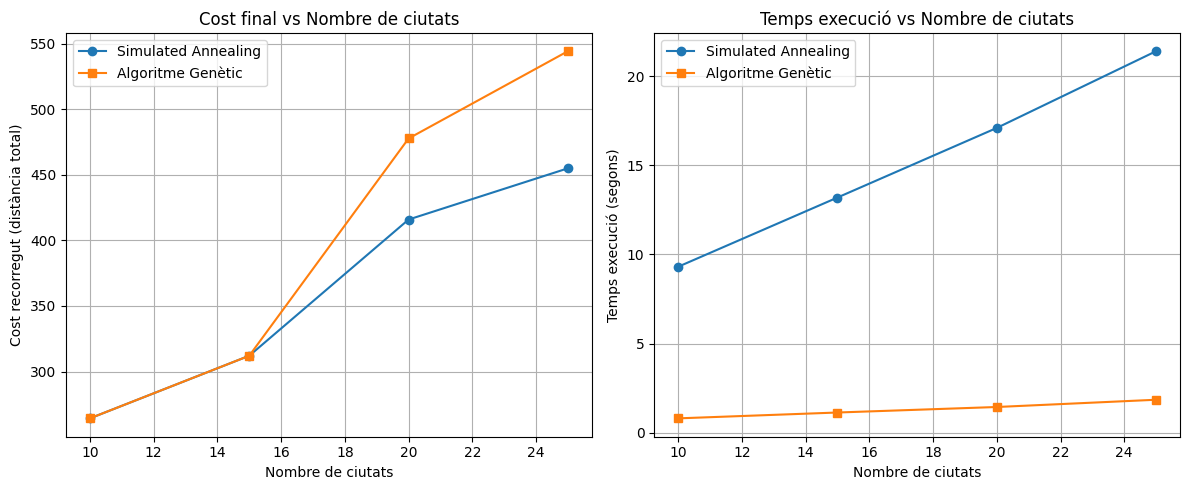

In [6]:
plt.figure(figsize=(12,5))

# Cost
plt.subplot(1,2,1)
plt.plot(n_ciutats_llista, resultats_totals['SA']['costs'], 'o-', label='Simulated Annealing')
plt.plot(n_ciutats_llista, resultats_totals['GA']['costs'], 's-', label='Algoritme Genètic')
plt.title('Cost final vs Nombre de ciutats')
plt.xlabel('Nombre de ciutats')
plt.ylabel('Cost recorregut (distància total)')
plt.legend()
plt.grid(True)

# Temps
plt.subplot(1,2,2)
plt.plot(n_ciutats_llista, resultats_totals['SA']['temps'], 'o-', label='Simulated Annealing')
plt.plot(n_ciutats_llista, resultats_totals['GA']['temps'], 's-', label='Algoritme Genètic')
plt.title('Temps execució vs Nombre de ciutats')
plt.xlabel('Nombre de ciutats')
plt.ylabel('Temps execució (segons)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Conclusions

En aquest treball hem implementat i comparat dues tècniques d’optimització per resoldre el problema del viatjant de comerç (TSP):  
**Simulated Annealing (SA)** i **Algoritmes Genètics (GA)**.

### Dificultat de codificació
- **Simulated Annealing**: Ha estat més senzill de programar, ja que només cal definir una funció de cost, una manera de generar veïns i una política de temperatura per acceptar canvis.
- **Algoritmes Genètics**: Més complex per gestionar la representació dels cromosomes, la selecció, el creuament i la mutació, especialment per assegurar que les solucions siguin vàlides (permutacions sense repeticions).

### Eficiència i rendiment
- En general, **SA** sol executar-se més ràpidament, ja que es centra en una sola solució que evoluciona, mentre que **GA** treballa amb poblacions completes, fet que augmenta el cost computacional.
- En termes de qualitat de solució, **GA** tendeix a trobar solucions de millor qualitat, especialment quan augmenta la mida del problema, degut a la seva capacitat de diversificar la recerca i combinar solucions bones.
- El temps d’execució d’ambdós mètodes creix amb el nombre de ciutats, però el creixement és més marcat en GA per la gestió de la població i les operacions genètiques.

### Reflexions finals
- La tria entre SA i GA depèn del context: si es prioritza la rapidesa i senzillesa, SA és més convenient; si es busca qualitat i es disposa de més temps, GA pot ser millor.
- Recomanem fer ajustaments de paràmetres (temperatura, taxa de mutació, mida població) per optimitzar cadascun dels mètodes segons el problema concret.
- El treball addicional ha permès entendre millor les característiques i fortaleses de cada tècnica d’optimització heurística.

Aquest estudi mostra la importància d’adaptar la tècnica al problema i recursos disponibles, així com de realitzar una anàlisi crítica més enllà de la simple implementació.
